In [1]:

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pylab as pl
import matplotlib.gridspec as gridspec


import json
#%pip install pandas
import pandas as pd
#%pip install seaborn
import seaborn as sns

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import pylab as pl


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3

Loading BokehJS ...

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from caiman.utils.visualization import plot_contours

import matplotlib as mpl
import matplotlib.cm as cmx
from matplotlib.ticker import MaxNLocator, MultipleLocator, LogFormatter


In [3]:
def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

    

In [4]:

def do_fft_analysis(avg_traces, idx, n_frames):
    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[idx]
    phase_data = phase_data[idx]

    # exclude DC offset from data
    mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

    #unpack values from frequency analysis
    mag_array = mag_data[freq_idx, :]
    phase_array = phase_data[freq_idx, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


# Select dataset

In [5]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522' #'20190505_JC083'
session_dir = os.path.join(rootdir, animalid, session)

fov = 'FOV1_zoom2p0x'
run_list = ['retino_run2']
run_label = 'retino_run2'
fnames = []
for run in run_list:
    fnames_tmp = glob.glob(os.path.join(session_dir, fov, '%s*' % run, 'raw*', '*.tif'))
    fnames.extend(fnames_tmp)
    print("[%s]: added %i tifs to queue." % (run, len(fnames_tmp)))

data_identifier = '|'.join([animalid, session, fov, run_label])

print("*** Dataset: %s ***" % data_identifier)

[retino_run2]: added 12 tifs to queue.
*** Dataset: JC084|20190522|FOV1_zoom2p0x|retino_run2 ***


# Load traces

In [6]:
from caiman.source_extraction.cnmf.cnmf import load_CNMF


In [7]:
results_dir = os.path.join(session_dir, fov, run_label, 'caiman_results')
glob.glob(os.path.join(results_dir, '*.hdf5'))

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/analysis_results.hdf5',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/analysis_results2.hdf5']

#### Load cnmf object

In [8]:
results_fpath = os.path.join(results_dir, 'analysis_results2.hdf5')
print(results_fpath)
cnm = load_CNMF(results_fpath, n_processes=8)
cnm.estimates.A.shape

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/analysis_results2.hdf5


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(262144, 208)

#### Load memmap file

In [9]:
# now load the file
fname_tots = glob.glob(os.path.join(session_dir, fov, run, 'raw*', 'full_memmap_*.mmap'))
print(fname_tots)
fname_new = fname_tots[0]


# Load images
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/full_memmap__d1_512_d2_512_d3_1_order_C_frames_26796_.mmap']


In [10]:
Av = images.mean(axis=0)


# Get experiment info

In [11]:
# Get acquisition info (SI):
# ----------------------------------------------------
run_dir = os.path.join(session_dir, fov, run)

run = os.path.split(run_dir)[-1]
with open(os.path.join(run_dir, '%s.json' % run), 'r') as fr:
    scan_info = json.load(fr)
frame_tsecs = np.array(scan_info['frame_tstamps_sec'])
ntiffs = scan_info['ntiffs']

# Need to make frame_tsecs span all TIFs:
frame_tsecs_ext = np.hstack([frame_tsecs for i in range(ntiffs)])
print(len(frame_tsecs_ext))

nframes_per_file = len(frame_tsecs)


# Get paradigm info (MW):
# ----------------------------------------------------
paradigm_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed*.json'))[0]
with open(paradigm_fpath, 'r') as f:
    mwinfo = json.load(f)

conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                       for cond in conditions)
print(trials_by_cond)


trial_nums = np.array([v for k,v in trials_by_cond.items()])
trial_nums = sorted(trial_nums.flatten())


26796
{'right': [2, 8, 12], 'left': [1, 4, 11], 'bottom': [3, 5, 9], 'top': [6, 7, 10]}


In [12]:
# Get cycle info:

curr_cond = 'right'
stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
stimperiod = 1./stimfreq # sec per cycle

n_frames = scan_info['nvolumes']
fr = scan_info['frame_rate']

n_cycles = int(round((n_frames/fr) / stimperiod))
#print n_cycles

n_frames_per_cycle = int(np.floor(stimperiod * fr))
cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')
print(len(cycle_starts))

12


# Format masks

In [13]:
# Filter out flat liners:

ncomps = cnm.estimates.A.shape[-1]
flat_rois = [rid for rid in range(ncomps) if all(np.diff(cnm.estimates.C[rid])==0)]
print("%i out of %i evaluated components are flat." % (len(flat_rois), ncomps))

print(flat_rois)

# get average traces across condition reps:
active_cells = [i for i in range(ncomps) if i not in flat_rois]
print("N active cells:", len(active_cells))

# Format masks
masks = []
for rid in active_cells:
    msk = np.reshape(cnm.estimates.A[:, rid].toarray(), dims, order='F')
    masks.append(msk)
    
masks = np.array(masks)
print("Mask array:", masks.shape)

0 out of 208 evaluated components are flat.
[]
N active cells: 208
Mask array: (208, 512, 512)


# Do fft and extract traces

In [194]:
# output_dir = os.path.join(results_dir, 'visualization', 'figure_panels')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

output_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/figure_panels'

In [15]:

# label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1/fr))
idx = np.argsort(freqs)
freqs=freqs[idx]
print(freqs)

# exclude DC offset from data
freqs=freqs[int(np.round(n_frames/2.))+1:]

# Identify freq idx:
freq_idx=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
top_freq_idx=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
print("Target freq: %.3f Hz" % freqs[freq_idx])
#max_mod_idx=np.argmax(magnitudes[freq_idx, :],0)#best pixel index


[-22.31640161 -22.29640484 -22.27640806 ...  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


In [16]:
#curr_cond = 'bottom'
magratios=[]
phases=[]
conds=[]
traces={}
for curr_cond in trials_by_cond.keys():
    avg_traces = []
    for rid in active_cells:
        tracemat = pd.DataFrame(np.reshape(cnm.estimates.C[rid], (nframes_per_file, ntiffs), order='F'), columns=trial_nums)
        avg = tracemat[trials_by_cond[curr_cond]].mean(axis=1)
        avg_traces.append(avg)
    avg_traces = pd.DataFrame(np.array(avg_traces).T, columns=active_cells)
    traces[curr_cond] = avg_traces

    magratio_array, phase_array = do_fft_analysis(avg_traces, idx, n_frames)

    magratios.append(magratio_array)
    phases.append(phase_array)
    conds.append(curr_cond)

In [17]:
magratios = pd.DataFrame(np.array(magratios).T, columns=conds)
phases = pd.DataFrame(np.array(phases).T, columns=conds)

In [18]:
ri_mx, ci_mx = np.where(magratios==magratios.max(axis=1).max())
max_mod_ix = int(ri_mx)
max_mod_condn = magratios.columns[int(ci_mx)]
print("max mag ratio ix: %i (cond %s)" % (max_mod_ix, max_mod_condn))

max mag ratio ix: 198 (cond right)


###### Look at 1 cell

(2233,)


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


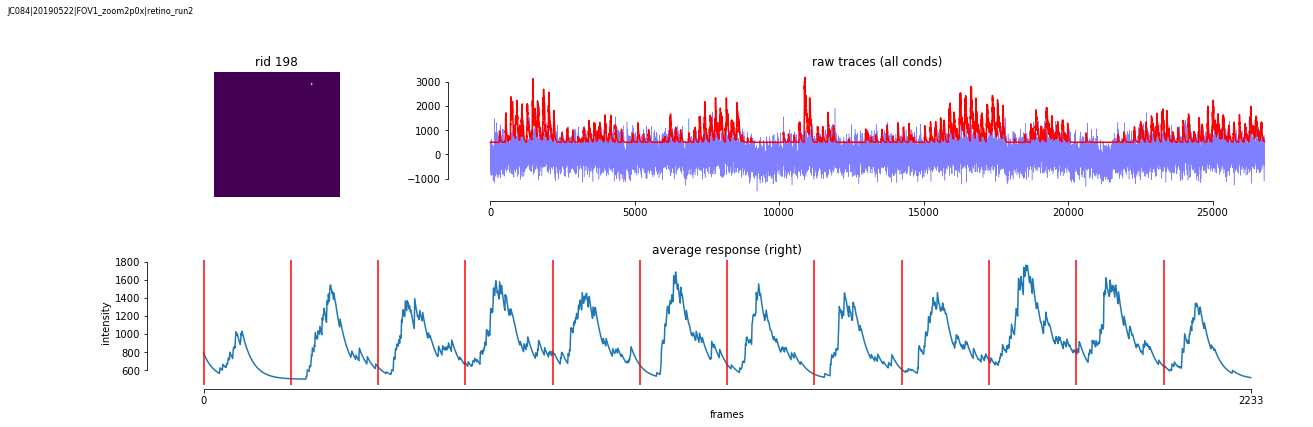

In [18]:
rid = 198 #max_mod_ix
curr_cond = 'right' #max_mod_condn

fig = pl.figure(constrained_layout=True, figsize=(20,6))
gspec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig, height_ratios=[1, 1])

ax1 = fig.add_subplot(gspec[0, 0])
ax1.imshow(np.reshape(cnm.estimates.A[:, rid].toarray(), cnm.dims, order='F'))
ax1.set_title('rid %i' % rid)
ax1.axis('off')

ax2 = fig.add_subplot(gspec[0, 1:])
ax2.plot(cnm.estimates.YrA[rid], 'b', alpha=0.5, lw=0.5)
ax2.plot(cnm.estimates.C[rid], 'r')
ax2.set_title('raw traces (all conds)')

ax3 = fig.add_subplot(gspec[1, 0:])
avg = traces[curr_cond][rid]
print(avg.shape)
ax3.plot(avg)
ax3.set_xticks([0, n_frames])
for cyc in cycle_starts:
    ax3.axvline(x=cyc, color='r')
ax3.set_title('average response (%s)' % curr_cond)
ax3.set_ylabel('intensity')
ax3.set_xlabel('frames')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.85, left=0.1, hspace=0.5)
label_figure(fig, data_identifier)

pl.savefig(os.path.join(output_dir, 'strongest_cell_%05d_%s.png' % (rid, curr_cond)))

# Create or load denoised movie:

In [19]:
import tifffile as tf
import pylab as pl

import copy

In [20]:
curr_cond = 'right'

print(curr_cond, trials_by_cond[curr_cond])

tot_n_frames = n_frames * len(trial_nums)
assert tot_n_frames == cnm.estimates.C.shape[-1], "Frame counts don't match!"

npix, ncomps = cnm.estimates.A.shape

right [2, 8, 12]


In [21]:
denoised_movie_fpath = os.path.join(output_dir, 'processed_videos', 'denoised_movie_processed_%s.tif' % curr_cond)

if not os.path.exists(denoised_movie_fpath):
    print("No movie found - creating new...")
    mov = np.empty((npix, n_frames), dtype=cnm.estimates.C.dtype)
    for tnum in trials_by_cond[curr_cond]:
        fr_ixs = [fi + ((tnum-1)*n_frames) for fi in np.arange(0, n_frames)]
        mov += cnm.estimates.A.dot(cnm.estimates.C[:, fr_ixs])
    mov = mov / len(trials_by_cond[curr_cond])
    print(mov.shape)  
    # Make save movie:

    # denoised = cm.movie(cnm2.estimates.A.dot(cnm2.estimates.C) + \
    #                     cnm2.estimates.b.dot(cnm2.estimates.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised = cm.movie(mov).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised_movie_fpath = os.path.join(output_dir, 'denoised_mov_av_%s.tif' % curr_cond)
    denoised.save(denoised_movie_fpath)

else:
    print("Loading movie for cond: %s" % curr_cond)
    denoised = tf.imread(denoised_movie_fpath)

print("movie:", denoised.shape)

Loading movie for cond: right
movie: (2233, 512, 512)


#### Find best cells to plot

In [21]:
print("Curr cond: %s" % curr_cond)
phase_array = phases[curr_cond]
magratio_array = magratios[curr_cond]

phase_array_cont =  -1 * phase_array
phase_array_cont = phase_array_cont % (2*np.pi)


Curr cond: right


In [22]:
mag_thr = 0.06
#strong_cells = [i for i in magratios.index.tolist() if all(magratios.iloc[i]>=mag_thr)]
strong_cells = [i for i in magratios.index.tolist() if magratios['left'][i]>=mag_thr]

len(strong_cells)

8

In [23]:
sorted_mags = [i for i in np.argsort(magratio_array)[::-1] if i in strong_cells] # sort high to low
sorted_phase = [i for i in np.argsort(phase_array_cont) if i in strong_cells] # sort smallest to highest

In [24]:
roi_list = copy.copy(sorted_phase)
print(roi_list)
for roi in roi_list:
    print(roi, phase_array_cont[roi], magratio_array[roi])

[186, 206, 196, 198, 13, 121, 180, 44]
186 0.3533256073982809 0.056666799779933566
206 0.7844838006153527 0.08342641639149426
196 2.43763653853135 0.08323636873347484
198 2.8049759993743133 0.10427009096773981
13 3.0202336794279163 0.005822006466932348
121 3.0259363966850317 0.009879265346300802
180 3.610513385879174 0.09513737135794051
44 3.7832965915391195 0.06279888407074494


In [25]:
#roi_list = [206, 152, 180, 198]
roi_list = [206, 198, 180]

In [168]:
sorted_mags

[198, 180, 206, 196, 44, 186, 121, 13]

# Get colormaps

In [33]:
# Load colormap
from matplotlib.colors import LinearSegmentedColormap

colormap = 'colorwheel'
cmapdir = '/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap = LinearSegmentedColormap.from_list('my_colormap', cdata)


In [34]:
phase_min = min([phase_array_cont[roi] for roi in roi_list])
phase_max = max([phase_array_cont[roi] for roi in roi_list])

#roi_colors = sns.color_palette('Spectral', len(roi_list))


norm = mpl.colors.Normalize(vmin=phase_min,vmax=phase_max)
#cmap = pl.cm.Spectral
roi_cdict = dict((roi, cmap(norm(phase_array_cont[roi]))) for roi in roi_list)



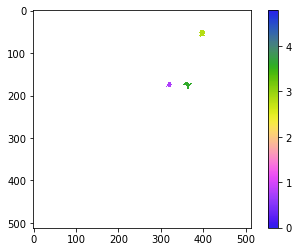

In [35]:
use_full_range = True

if use_full_range:
    vmax = 2*np.pi-1.5 #phase_max
    vmin = 0 # phase_min
else:
    vmax = phase_max
    vmin = phase_min

norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
#cmap = pl.cm.Spectral_r
roi_cdict = dict((roi, cmap(norm(phase_array_cont[roi]))) for roi in roi_list)
#cmap_name = 'Spectral_r'

nrois, d1, d2 = masks.shape

all_masks = np.ones((d1, d2), dtype=phase_array_cont.dtype) * 100
for rid in roi_list:
    tmp_mask = masks[rid, :, :].copy()
    tmp_mask[tmp_mask > 0] = 1. * phase_array_cont[rid]
    msk = np.ma.masked_where(tmp_mask==0, tmp_mask)
    
    all_masks[tmp_mask > 0] = 1. * phase_array_cont[rid]



mask_overlay = np.ma.masked_where(all_masks==100, all_masks)
pl.figure()
pl.imshow(mask_overlay, cmap=cmap, vmin=vmin, vmax=vmax)
pl.colorbar()


In [38]:
xticks = np.linspace(0, n_frames, 5)
xticklabels = [round(float(f)/fr) for f in xticks]


example-traces_cond-right_cmap-black_JC084-20190522-retino_run2-caiman


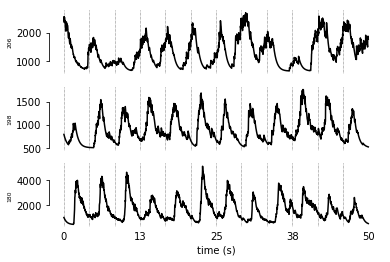

In [50]:
skey = '-'.join([animalid, session, run_label, 'caiman'])

fig, axes = pl.subplots(3, 1, figsize=(6,4), sharex=True, sharey=False)
for ri, (ax, rid) in enumerate(zip(axes, roi_list)):
    ax.plot(traces[curr_cond][rid], color='k')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_ylabel(rid, fontsize=6)
        
ax.set_xlabel('time (s)')

figname = 'example-traces_cond-%s_cmap-%s_%s' % (curr_cond, 'black', skey)
pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

example-traces_cond-right_cmap-colorwheel_JC084-20190522-retino_run2-caiman


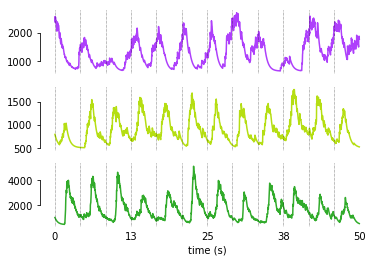

In [49]:
skey = '-'.join([animalid, session, run_label, 'caiman'])

fig, axes = pl.subplots(3, 1, figsize=(6,4), sharex=True, sharey=False)
for ri, (ax, rid) in enumerate(zip(axes, roi_list)):
    ax.plot(traces[curr_cond][rid], color=roi_cdict[rid])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
        
ax.set_xlabel('time (s)')

figname = 'example-traces_cond-%s_cmap-%s_%s' % (curr_cond, colormap, skey)
pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

right


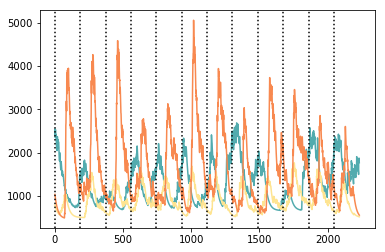

In [28]:
fig, axes = pl.subplots( pl.figure()
print(curr_cond)
for rid in roi_list:
    pl.plot(traces[curr_cond][rid], color=roi_cdict[rid])
for cyc in cycle_starts:
    pl.axvline(x=cyc,color='k', linestyle=':')

In [29]:
roi_list

[206, 198, 180]

#### Create stimulus movie

In [30]:
stim_mov_fpath = os.path.join(output_dir, '%s_stimulus.tif' % curr_cond)
if os.path.exists(stim_mov_fpath):
    print("Loading stimulus movie: %s" % stim_mov_fpath)
    stimulus_mov = tf.imread(stim_mov_fpath)
else:
    print("Creating stimulus movie: %s" % curr_cond)
    mw_start_ixs = mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['start_indices']

    mwpos = np.array(mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['values'][0:mw_start_ixs[1]])
    len(mwpos)
    mwpos = mwpos - mwpos.min()

    iframes = np.linspace(mwpos[0], mwpos[-1], n_frames_per_cycle)

    allpos = np.array(mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['values'])
    stimsize = len(iframes) #int(np.ceil(allpos.max() - allpos.min()))
    print(stimsize)

    # Create stimulus:
    stimulus = np.zeros((stimsize, stimsize), dtype=np.int8)
    if curr_cond in ['left', 'right']:
        stimulus[:, 0:2] = 1
    else:
        stimulus[0:2, :] = 1

    direction = -1 if curr_cond in ['right', 'top'] else 1
    iframes = [int(round(i)) for i in iframes]
    pos_int = 0
    stim_list=[]
    for fi, fpos in enumerate(iframes):
        stimulus = np.roll(stimulus, direction, axis=1)
        stim_list.append(stimulus)
    stim_mov = np.array(stim_list)

    # Save movie:
    stimulus_mov = np.vstack([stim_mov for _ in range(n_cycles)]) * 255
    tf.imsave(stim_mov_fpath, stimulus_mov)
    
print("Stimulus mov:", stimulus_mov.shape)

Loading stimulus movie: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/visualization/right_stimulus.tif
Stimulus mov: (2232, 186, 186)


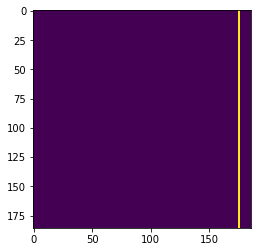

In [31]:
pl.figure()
pl.imshow(stimulus_mov[10, :, :])

In [32]:
trials_by_cond

{'right': [2, 8, 12],
 'top': [6, 7, 10],
 'bottom': [3, 5, 9],
 'left': [1, 4, 11]}

In [33]:
n_frames_per_cycle

186

#### Create legend for widefield stimulus

In [57]:
n_frames_per_cycle = int(round((1/.13) * 25.))
n_frames_per_cycle

print("Creating stimulus movie: %s" % curr_cond)
mw_start_ixs = mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['start_indices']

mwpos = np.array(mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['values'][0:mw_start_ixs[1]])
len(mwpos)
mwpos = mwpos - mwpos.min()


iframes = np.linspace(mwpos[0], mwpos[-1], n_frames_per_cycle)
stim_mov_fpath = os.path.join(output_dir, 'widefield_stimulus_right.tif')

allpos = np.array(mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['values'])
stimsize = len(iframes) #int(np.ceil(allpos.max() - allpos.min()))
print(stimsize)

# Create stimulus:
stimulus = np.zeros((stimsize, stimsize), dtype=np.int8)
if curr_cond in ['left', 'right']:
    stimulus[:, 0:2] = 1
else:
    stimulus[0:2, :] = 1

direction = -1 if curr_cond in ['right', 'top'] else 1
iframes = [int(round(i)) for i in iframes]
pos_int = 0
stim_list=[]
for fi, fpos in enumerate(iframes):
    stimulus = np.roll(stimulus, direction, axis=1)
    stim_list.append(stimulus)
stim_mov = np.array(stim_list)

# Save movie:
stimulus_mov = np.vstack([stim_mov for _ in range(2)]) * 255
tf.imsave(stim_mov_fpath, stimulus_mov)

Creating stimulus movie: right
192


In [34]:
stimulus_mov.shape

(2232, 186, 186)

#### Test with 1 frame

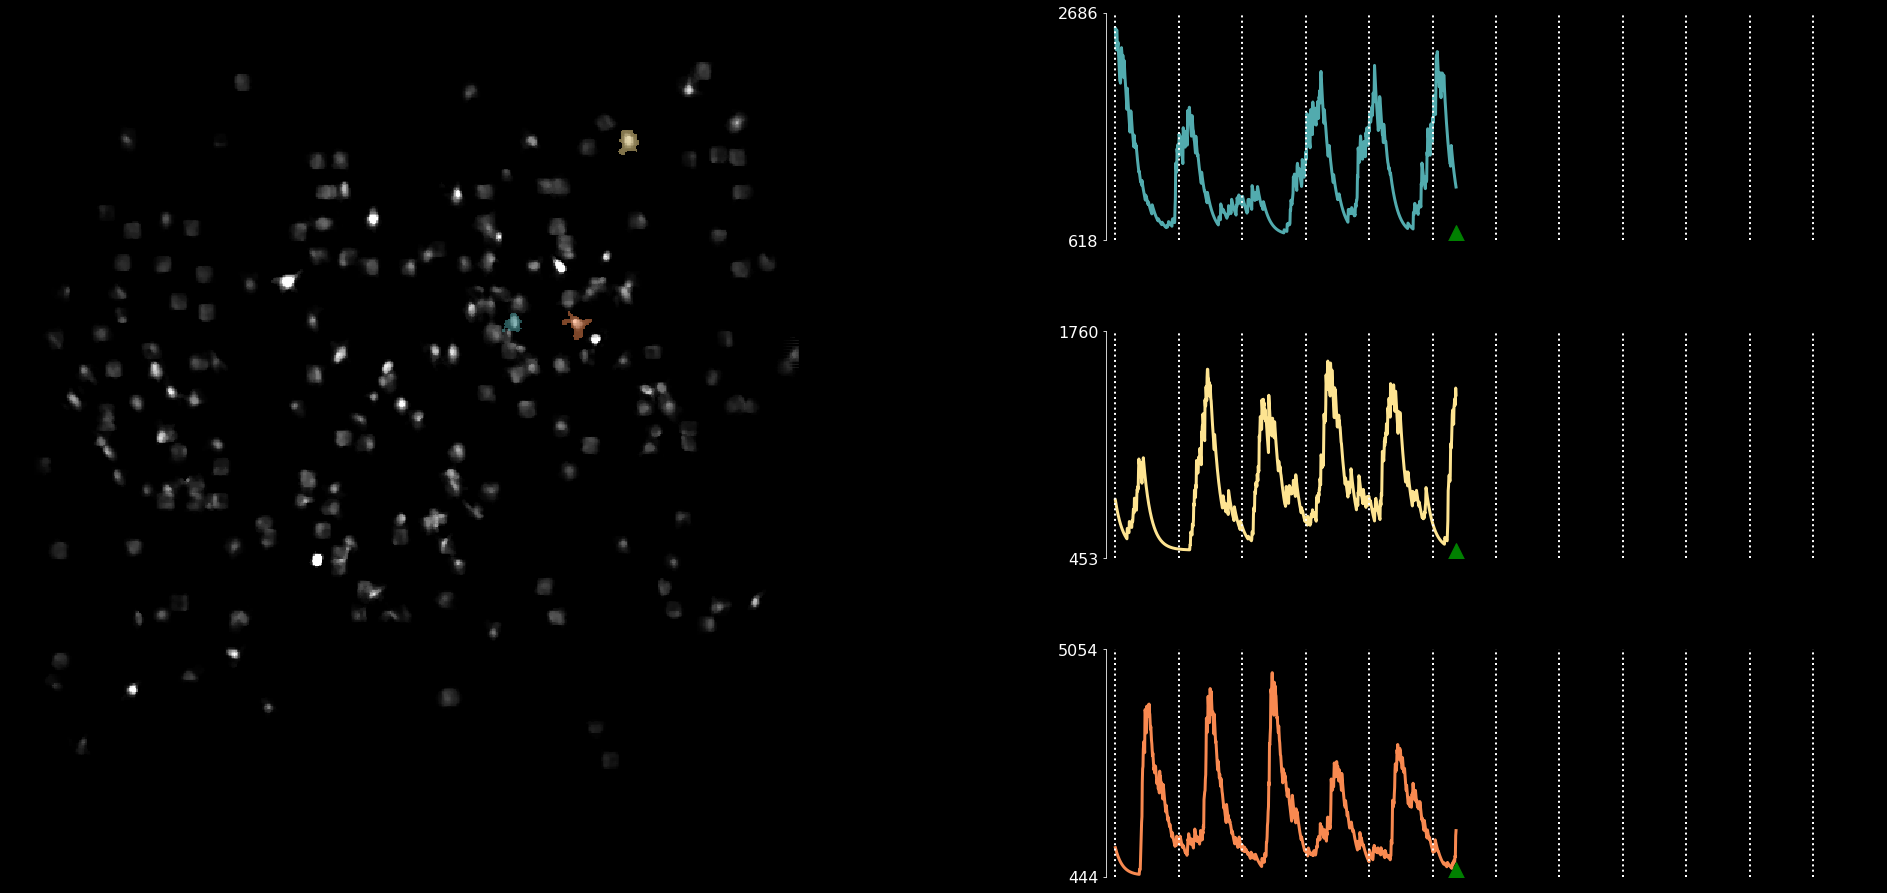

In [35]:
index = 1000

test_fig = os.path.join(output_dir, 'experiment_movie_test.png')

transparent = True
lw = 3
stim_marker_size = 30

if transparent:
    fig_color = 'k'
    fig.patch.set_alpha(1)
    fig.patch.set_facecolor('k')
    lc = 'w'
    pl.rcParams['savefig.facecolor']='k'
else:
    fig_color = 'w'
    fig.patch.set_alpha(1.)
    lc = 'k'
        
fig = pl.figure(figsize=(32, 20), facecolor=fig_color)
    
nr = len(roi_list)
nc = 2

nframes = stimulus_mov.shape[0]
rspan = nr
ax0 = pl.subplot2grid((nr, nc), (0, 0), colspan=1, rowspan=nr)
ax0.imshow(denoised[index, :, :], cmap='gray')
ax0.imshow(mask_overlay, cmap=cmap_name, vmin=vmin, vmax=vmax, alpha=0.5)
ax0.axis('off')


for ri, roi in enumerate(roi_list):
    ax = plt.subplot2grid((nr, nc), (ri, 1), colspan=nc-1, rowspan=1)
    ax.set_xlim([0-20, nframes])
    if transparent:
        ax.patch.set_alpha(1.)
        ax.set_facecolor('k')
    ax.plot(traces[curr_cond][roi][0:index], color=roi_cdict[roi], lw=lw)
    ax.set_xticks([])
    curr_ymin = int(round(traces[curr_cond][roi].min()))
    curr_ymax = int(round(traces[curr_cond][roi].max()))
    yticks = [curr_ymin-50, curr_ymax]
    ax.set_ylim(yticks)
    ax.set_yticks(yticks)
    sns.despine(ax=ax, bottom=True, trim=True, offset=3)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, color=lc, linestyle=':', lw=lw-1, alpha=1.0)
    ax.plot(index, curr_ymin-50, marker='^', color='g', markersize=stim_marker_size)
    ax.spines['left'].set_color(lc)
    ax.yaxis.label.set_color(lc)
    ax.tick_params(axis='y', colors=lc, labelsize=16)

pl.subplots_adjust(top=0.8, hspace=0.4, wspace=0.4, left=0.1, right=0.9, bottom=0.2)

pl.savefig(test_fig)


#### Save template

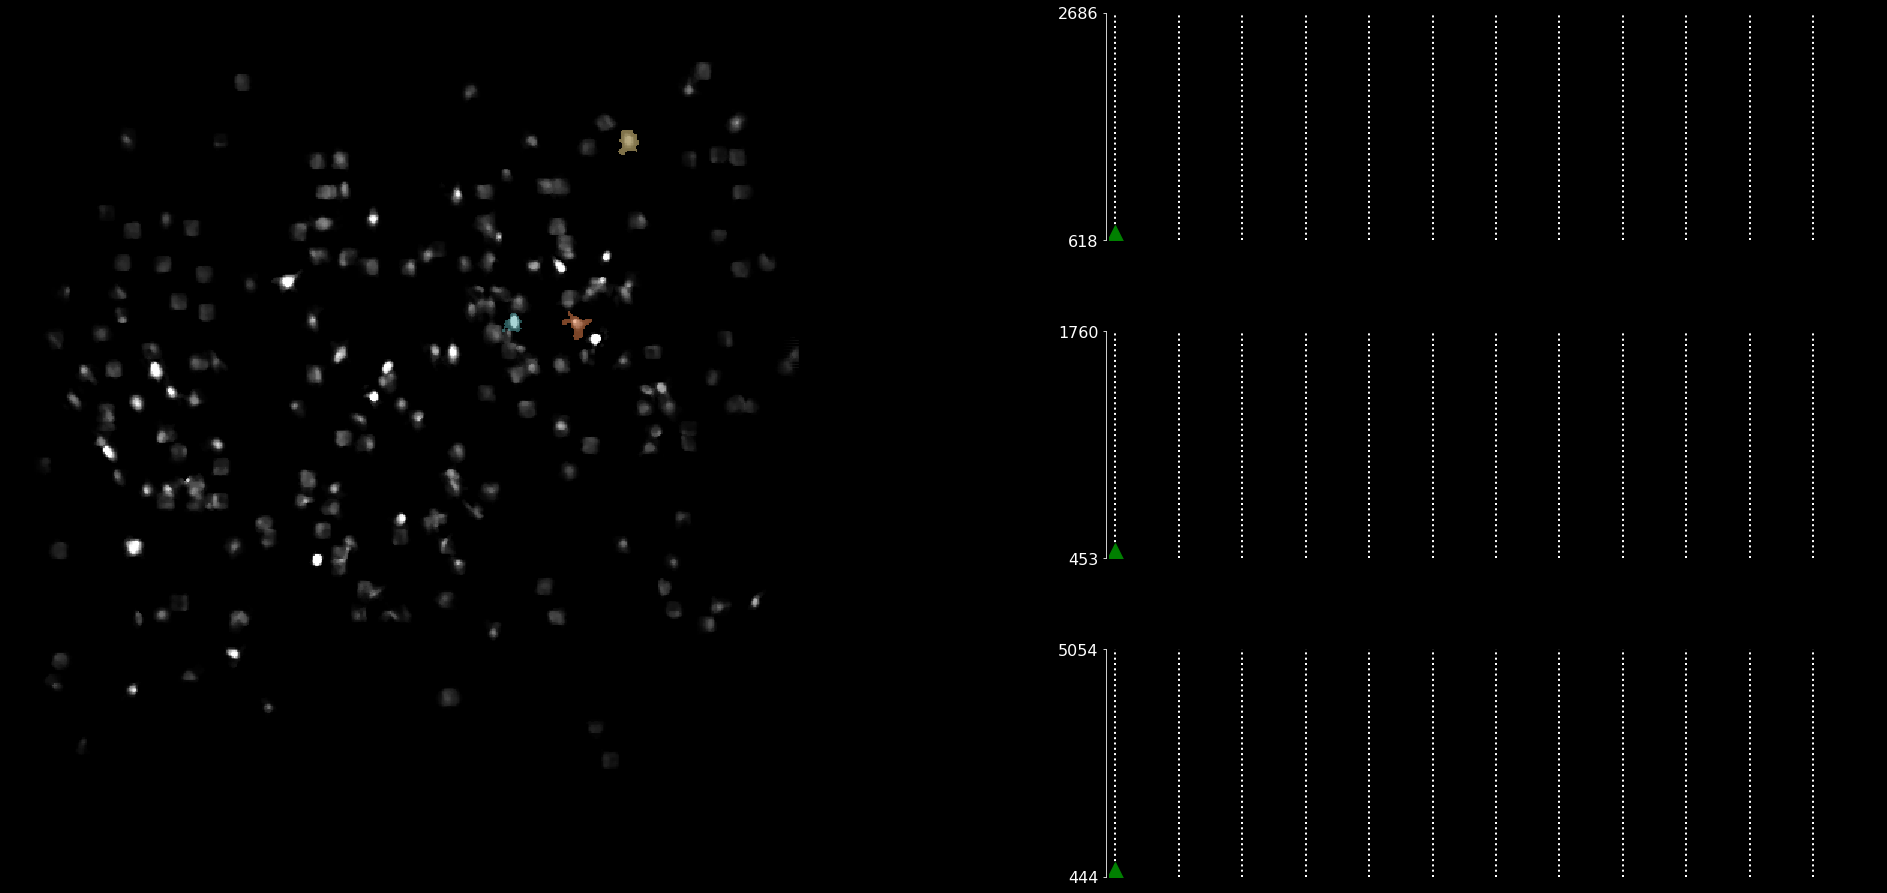

In [77]:
index = 0

template_fig = os.path.join(output_dir, 'experiment_movie_template.png')

transparent = True
lw = 3
stim_marker_size = 30

    
if transparent:
    fig_color = 'k'
    fig.patch.set_alpha(1)
    fig.patch.set_facecolor('k')
    lc = 'w'
    pl.rcParams['savefig.facecolor']='k'
else:
    fig_color = 'w'
    fig.patch.set_alpha(1.)
    lc = 'k'
        
fig = pl.figure(figsize=(32, 20), facecolor=fig_color)
nr = len(roi_list)
nc = 2

nframes = stimulus_mov.shape[0]
rspan = nr
ax0 = pl.subplot2grid((nr, nc), (0, 0), colspan=1, rowspan=nr)
ax0.imshow(denoised[index, :, :], cmap='gray')
ax0.imshow(mask_overlay, cmap=cmap_name, vmin=vmin, vmax=vmax, alpha=0.5)
ax0.axis('off')


for ri, roi in enumerate(roi_list):
    ax = plt.subplot2grid((nr, nc), (ri, 1), colspan=nc-1, rowspan=1)
    ax.set_xlim([0-20, nframes])
    if transparent:
        ax.patch.set_alpha(1.)
        ax.set_facecolor('k')
    ax.plot(traces[curr_cond][roi][0:index], color=roi_cdict[roi], lw=lw)
    ax.set_xticks([])
    curr_ymin = int(round(traces[curr_cond][roi].min()))
    curr_ymax = int(round(traces[curr_cond][roi].max()))
    yticks = [curr_ymin-50, curr_ymax]
    ax.set_ylim(yticks)
    ax.set_yticks(yticks)
    sns.despine(ax=ax, bottom=True, trim=True, offset=3)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, color=lc, linestyle=':', lw=lw-1, alpha=1.0)
    ax.plot(index, curr_ymin-50, marker='^', color='g', markersize=stim_marker_size)
    ax.spines['left'].set_color(lc)
    ax.yaxis.label.set_color(lc)
    ax.tick_params(axis='y', colors=lc, labelsize=16)

pl.subplots_adjust(top=0.8, hspace=0.4, wspace=0.4, left=0.1, right=0.9, bottom=0.2)


pl.savefig(template_fig)


In [34]:

nframes = stimulus_mov.shape[0]
nframes_digits=int(np.ceil(np.log10(nframes)))

tmpfolder = os.path.join(output_dir, 'tmp-frames')
if not os.path.exists(tmpfolder):
    os.makedirs(tmpfolder)
    

In [37]:
tmpfolder + "/file"+str(index).zfill(nframes_digits)+".png"

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/visualization/tmp-frames/file1000.png'

In [44]:
len(os.listdir(tmpfolder))

2232

In [38]:
#vmin = phase_min
#vmax = phase_max
lw = 3

for index in np.arange(1623, nframes): #range(nframes): #np.arange(4343, nframes)): # range(nframes)

    imagename = tmpfolder + "/file"+str(index).zfill(nframes_digits)+".png"

    if transparent:
        fig_color = 'k'
        fig.patch.set_alpha(1)
        fig.patch.set_facecolor('k')
        lc = 'w'
        pl.rcParams['savefig.facecolor']='k'
    else:
        fig_color = 'w'
        fig.patch.set_alpha(1.)
        lc = 'k'

    fig = pl.figure(figsize=(32, 20), facecolor=fig_color)

    nr = len(roi_list)
    nc = 2

    nframes = stimulus_mov.shape[0]
    rspan = nr
    ax0 = pl.subplot2grid((nr, nc), (0, 0), colspan=1, rowspan=nr)
    ax0.imshow(denoised[index, :, :], cmap='gray')
    ax0.imshow(mask_overlay, cmap=cmap_name, vmin=vmin, vmax=vmax, alpha=0.5)
    ax0.axis('off')


    for ri, roi in enumerate(roi_list):
        ax = plt.subplot2grid((nr, nc), (ri, 1), colspan=nc-1, rowspan=1)
        ax.set_xlim([0-20, nframes])
        if transparent:
            ax.patch.set_alpha(1.)
            ax.set_facecolor('k')
        ax.plot(traces[curr_cond][roi][0:index], color=roi_cdict[roi], lw=lw)
        ax.set_xticks([])
        curr_ymin = int(round(traces[curr_cond][roi].min()))
        curr_ymax = int(round(traces[curr_cond][roi].max()))
        yticks = [curr_ymin-50, curr_ymax]
        ax.set_ylim(yticks)
        ax.set_yticks(yticks)
        sns.despine(ax=ax, bottom=True, trim=True, offset=3)
        for cyc in cycle_starts:
            ax.axvline(x=cyc, color=lc, linestyle=':', lw=lw-1, alpha=1.0)
        ax.plot(index, curr_ymin-50, marker='^', color='g', markersize=stim_marker_size)
        ax.spines['left'].set_color(lc)
        ax.yaxis.label.set_color(lc)
        ax.tick_params(axis='y', colors=lc, labelsize=16)

    pl.subplots_adjust(top=0.8, hspace=0.4, wspace=0.4, left=0.1, right=0.9, bottom=0.2)

    pl.savefig(imagename)
    pl.close("all")

In [41]:
import subprocess

In [43]:
fr

44.6528

In [45]:
delete = False
outputframerate = 120.
videooutname = os.path.join(output_dir, 'EXP_movie_%s_%icells2.mp4' % (curr_cond, len(roi_list)))


# #### Save movie

start= os.getcwd()
os.chdir(tmpfolder)
print("All labeled frames were created, now generating video...")
## One can change the parameters of the video creation script below:
# See ffmpeg user guide: http://ffmpeg.org/ffmpeg.html#Video-and-Audio-file-format-conversion
# 
try: 
    subprocess.call([
        'ffmpeg', '-framerate', 
        str(fr), '-i', 'file%0'+str(nframes_digits)+'d.png', '-r', str(outputframerate), videooutname])
except FileNotFoundError:
    print("Ffmpeg not correctly installed, see https://github.com/AlexEMG/DeepLabCut/issues/45")

if delete:
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
os.chdir(start)

All labeled frames were created, now generating video...


In [50]:
videooutname

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/visualization/experiment_movie_left_6cells.mp4'

In [ ]:

    fig, ax = pl.subplots(figsize=figsize)
    #offset = 200
    last_y = 0
    for ri,rid in enumerate(sorted_list):
        cval = scalarmap.to_rgba(hue_values[rid])
        im = ax.plot(avg_traces[rid] + last_y, color=cval, lw=1, alpha=0.8)
        last_y = avg_traces[rid].mean() + ri*offset

    for cyc in stimlines:
        ax.axvline(x=cyc, color='k', linestyle=':', lw=0.75, alpha=0.5)

    sns.despine(trim=True, offset=8, left=True, bottom=True)
    if label_rois:
        ax.set_yticks([ri*offset + avg_traces[rid].mean() for ri,rid in enumerate(sorted_list)])
        ax.set_yticklabels([rid for rid in sorted_list])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    pl.subplots_adjust(left=0.01, top=0.9, right=0.85)


# FFT analysis

In [96]:
masks.max()

0.34855024802030704

In [106]:

def mask_rois(masks, value_array, mask_thr=0.1):
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)
    
    #masked = np.ma.masked_where(mask == 0, mask)

    
    value_mask =  np.ones(dims)*-100
    for rid in value_array.index.tolist():
        value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask

In [107]:
def plot_overlaid_maps(curr_cond, phases, magratios, mag_thr=0.03, mask_thr=0.1):

    phase_array = phases[curr_cond]
    magratio_array = magratios[curr_cond]

    phase_array_cont =  -1 * phase_array
    phase_array_cont = phase_array_cont % (2*np.pi)

    phase_mask_tmp = mask_rois(masks, phase_array_cont, mask_thr=mask_thr)
    magratio_mask_tmp = mask_rois(masks, magratio_array, mask_thr=mask_thr)
    
    phase_mask = np.ma.masked_where(magratio_mask_tmp==-100, phase_mask_tmp)
    magratio_mask = np.ma.masked_where(magratio_mask_tmp==-100, magratio_mask_tmp)
    
    #magratio_mask_thr = np.copy(magratio_mask)
    #magratio_mask_thr[magratio_mask<mag_thr] = np.nan
    magratio_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, magratio_mask)
    print("max magratio:", magratio_array.max())

    #phase_mask_thr = np.copy(phase_mask)
    #phase_mask_thr[magratio_mask<mag_thr] = np.nan
    phase_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, phase_mask)
    print("max phase:", phase_mask_thr.max())


    fig, axes = pl.subplots(1,3, figsize=(12,5))
    ax = axes[0]
    im = ax.imshow(cnm.estimates.Cn, cmap='gray'); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[1]
    axes[1].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(magratio_mask_thr, cmap='inferno', alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[2]
    axes[2].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(phase_mask_thr, cmap='nipy_spectral', vmin=0, vmax=2*np.pi, alpha=0.7); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig

In [108]:

# adjust elevation limit to show only monitor extent
screeninfo_fpath = glob.glob(os.path.join(rootdir, animalid, 'epi_maps', '*.json'))[0]
with open(screeninfo_fpath, 'r') as f:
    screen = json.load(f)

screen_width = screen['screen_params']['screen_size_x_degrees']
screen_height = screen['screen_params']['screen_size_t_degrees']

screen_left = -1*screen_width/2.
screen_right = screen_width/2.
screen_top = screen_height/2.
screen_bottom = -1*screen_height/2.
    
elev_cutoff = screen_top / screen_right
print("[AZ]: screen bounds: (%.2f, %.2f)" % (screen_left, screen_right))
print("[EL]: screen bounds: (%.2f, %.2f)" % (screen_top, screen_bottom))


[AZ]: screen bounds: (-58.78, 58.78)
[EL]: screen bounds: (33.66, -33.66)


In [109]:
mag_thr = 0.02
all_conds_pass = True

if all_conds_pass:
    strong_cells = [i for i in magratios.index.tolist() if all(magratios.iloc[i]>=mag_thr)]
else:
    strong_cells = [i for i in magratios.index.tolist() if any(magratios.iloc[i]>=mag_thr)]


print("%i out of %i cells meet min mag-thr of %.2f for all conds." % (len(strong_cells), magratios.shape[0], mag_thr))

71 out of 208 cells meet min mag-thr of 0.02 for all conds.


In [110]:
phases_cont = -1 * phases
phases_cont = phases_cont % (2*np.pi)

In [111]:
use_cont = True
filter_by_mag = True
mask_thr=0.01

if use_cont:
    elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
    azim = (phases_cont['left'] - phases_cont['right']) / 2.

    vmin = -np.pi
    vmax = np.pi
    
else:
    elev = (phases['bottom'] - phases['top']) / 2.
    azim = (phases['left'] - phases['right']) / 2.

    elev_c = -1 * elev
    elev_c = elev_c % (2*np.pi)

    azim_c = -1 * azim
    azim_c = azim_c % (2*np.pi)

    vmin = 0
    vmax = 2*np.pi
    
    azim = copy.copy(azim_c)
    elev = copy.copy(elev_c)

magratios_all = magratios.mean(axis=1)
    
if filter_by_mag:
    azim_phase = mask_rois(masks, azim[strong_cells], mask_thr=mask_thr)
    elev_phase = mask_rois(masks, elev[strong_cells], mask_thr=mask_thr)
else:
    azim_phase = mask_rois(masks, azim, mask_thr=mask_thr)
    elev_phase = mask_rois(masks, elev, mask_thr=mask_thr)

azim_phase_mask = np.ma.masked_where(azim_phase==-100, azim_phase)
elev_phase_mask = np.ma.masked_where(elev_phase==-100, elev_phase)

    

In [120]:
tmpm = masks[roi, :, :].copy()
tmpm[masks[roi, :, :]>0]=np.nan
xp, yp = np.where(masks[roi, :, :])
xp[0]

167

absolute_maps_filter_allconds_magthr_0.00_71cells


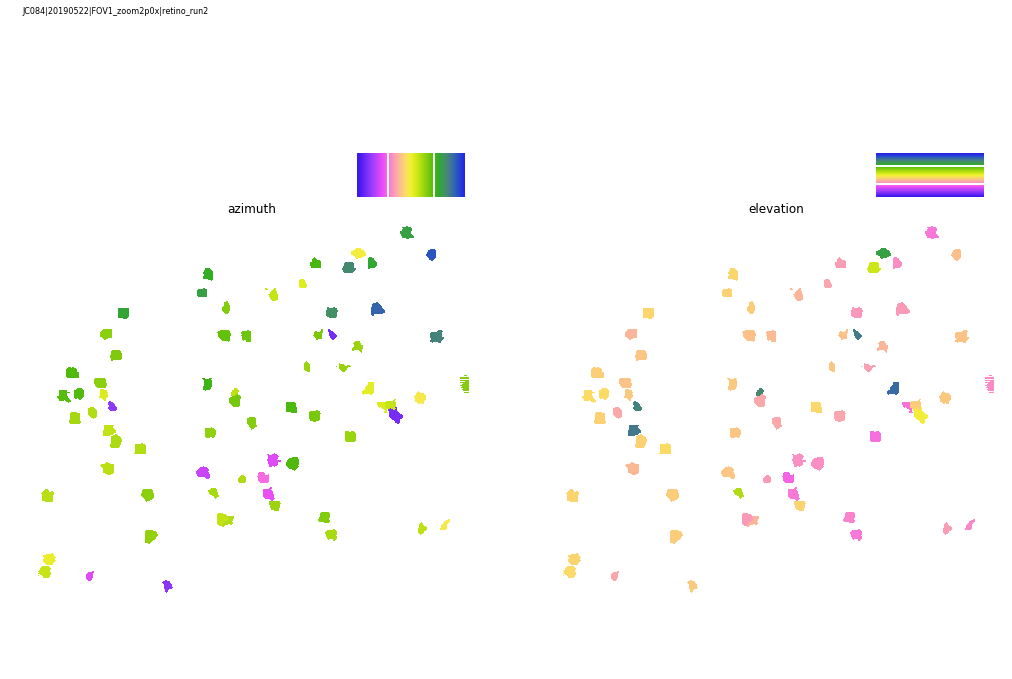

In [266]:
label = False
label_str = '_labeled' if label else ''
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin, vmax)
alpha = 1


fig, axes = pl.subplots(1,2, figsize=(15, 12))
fig.patch.set_alpha(0)
# -- azimuth --
ax = axes[0]

ax.patch.set_alpha(0)
ax.imshow(Av, cmap='gray', alpha=0); ax.axis('off');
im1 = ax.imshow(azim_phase_mask, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('azimuth')
ax.set_frame_on(True)

if label:
    for roi in strong_cells:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')

    
# -- elevation --
ax = axes[1]
ax.patch.set_alpha(0)

ax.imshow(Av, cmap='gray', alpha=0); ax.axis('off');
im2 = ax.imshow(elev_phase_mask, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('elevation')

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')



# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.


cbar1_orientation='horizontal'
cbar1_axes = [0.31, 0.78, 0.1, 0.05]
cbar2_orientation='vertical'
cbar2_axes = [0.79, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)

pl.subplots_adjust(left=0.01, right=0.9)

if filter_by_mag:
    if all_conds_pass:
        figname = 'absolute_maps_filter_allconds_magthr_%.2f_%icells' % (mag_thr, len(strong_cells))
    else:
        figname = 'absolute_maps_filter_maxcond_magthr_%.2f_%icells' % (mag_thr, len(strong_cells))
else:
    figname = 'absolute_maps_all_cells'

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, '%s%s_nobackground.png' % (figname, label_str)))

print(figname)

absolute_maps_filter_allconds_magthr_0.02_71cells


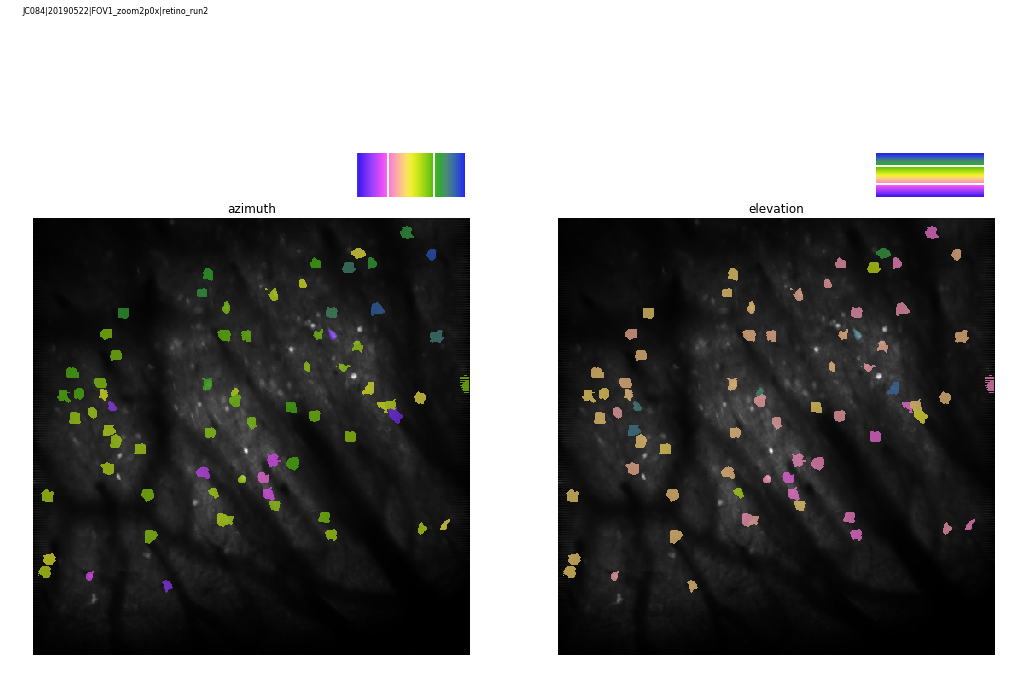

In [185]:
label = False
label_str = '_labeled' if label else ''
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin, vmax)
alpha = 0.7

fig, axes = pl.subplots(1,2, figsize=(15, 12))
# -- azimuth --
ax = axes[0]
ax.imshow(Av, cmap='gray'); ax.axis('off');
im1 = ax.imshow(azim_phase_mask, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('azimuth')

if label:
    for roi in strong_cells:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')

    
# -- elevation --
ax = axes[1]
ax.imshow(Av, cmap='gray'); ax.axis('off');
im2 = ax.imshow(elev_phase_mask, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('elevation')

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')



# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.


cbar1_orientation='horizontal'
cbar1_axes = [0.31, 0.78, 0.1, 0.05]
cbar2_orientation='vertical'
cbar2_axes = [0.79, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)

pl.subplots_adjust(left=0.01, right=0.9)

if filter_by_mag:
    if all_conds_pass:
        figname = 'absolute_maps_filter_allconds_magthr_%.2f_%icells' % (mag_thr, len(strong_cells))
    else:
        figname = 'absolute_maps_filter_maxcond_magthr_%.2f_%icells' % (mag_thr, len(strong_cells))
else:
    figname = 'absolute_maps_all_cells'

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, '%s%s.png' % (figname, label_str)))

print(figname)

In [190]:
rois_to_plot = [198, 180, 196]

In [191]:
sorted_mags

[198, 180, 206, 196, 44, 186, 121, 13]

example-traces_cond-right_cmap-black_JC084-20190522-retino_run2-caiman


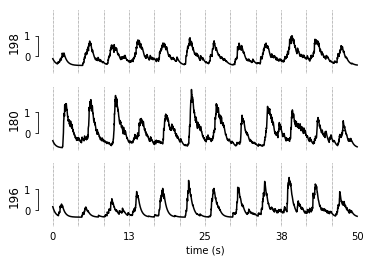

In [193]:
tmp_rlist = copy.copy(sorted_mags) #[180, 13, 198, 196] #, 44] # 122
skey = '-'.join([animalid, session, run_label, 'caiman'])
nrois2plot  = len(rois_to_plot)

fig, axes = pl.subplots(nrois2plot, 1, figsize=(6,4), sharex=True, sharey=True)
for ri, (ax, rid) in enumerate(zip(axes, rois_to_plot)):
    values = traces['right'][rid]
    t = (values - np.mean(values) ) / np.mean(values)
    ax.plot(t, color='k')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_ylabel(rid, fontsize=12)
        
ax.set_xlabel('time (s)')

figname = 'example-traces_cond-%s_cmap-%s_%s' % (curr_cond, 'black', skey)
pl.savefig(os.path.join(output_dir, '%s.png' % figname))
print(figname)

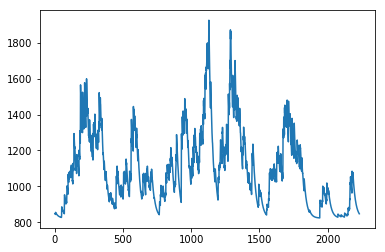

In [133]:
pl.figure()
pl.plot((traces['right'][rid] + traces['left'][rid][::-1]) / 2.)

In [90]:
1- elev_cutoff/2.

0.7136614652802352

In [91]:
elev_cutoff/2.

0.2863385347197648

# Pixel maps

In [236]:
import re
import h5py
import scipy.stats as spstats

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def correct_phase_wrap(phase):
        
    corrected_phase = phase.copy()
    
    corrected_phase[phase<0] =- phase[phase<0]
    corrected_phase[phase>0] = (2*np.pi) - phase[phase>0]
    
    return corrected_phase

In [237]:
def trials_to_dataframes(processed_fpaths, conditions_fpath):
    
    # Get condition / trial info:
    with open(conditions_fpath, 'r') as f:
        conds = json.load(f)
    cond_list = list(set([cond_dict['stimuli']['stimulus'] for trial_num, cond_dict in conds.items()]))
    trials_by_cond = dict((cond, [int(k) for k, v in conds.items() if v['stimuli']['stimulus']==cond]) for cond in cond_list)

    excluded_tifs = [] 
    for cond, tif_list in trials_by_cond.items():
        for tifnum in tif_list:
            processed_tif = [f for f in processed_fpaths if 'File%03d' % tifnum in f]
            if len(processed_tif) == 0:
                print("No analysis found for file: %s" % tifnum)
                excluded_tifs.append(tifnum)
        trials_by_cond[cond] = [t for t in tif_list if t not in excluded_tifs]
    print("TRIALS BY COND:")
    print(trials_by_cond) 
    trial_list = [int(t) for t in conds.keys() if int(t) not in excluded_tifs]
    print("Trials:", trial_list)

    fits = []
    phases = []
    mags = []
    for trial_num, trial_fpath in zip(sorted(trial_list), sorted(processed_fpaths, key=natural_keys)):
        
        print("%i: %s" % (trial_num, os.path.split(trial_fpath)[-1]))
        df = h5py.File(trial_fpath, 'r')
        fits.append(pd.Series(data=df['var_exp_array'][:], name=trial_num))
        phases.append(pd.Series(data=df['phase_array'][:], name=trial_num))
        mags.append(pd.Series(data=df['mag_ratio_array'][:], name=trial_num))
        df.close()
        
    fit = pd.concat(fits, axis=1)
    magratio = pd.concat(mags, axis=1)
    phase = pd.concat(phases, axis=1)
    
    return fit, magratio, phase, trials_by_cond



def get_retino_stimulus_info(mwinfo, runinfo):
    conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
    trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                           for cond in conditions)
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))
        #print n_cycles

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts,
                               #'trials_by_cond': trials_by_cond,
                               'frame_tstamps': runinfo['frame_tstamps_sec']
                              }

    return stiminfo, trials_by_cond




def filter_map_by_magratio(magratio, phase, dims=(512, 512), ds_factor=2, cond='right', mag_thr=None, mag_perc=0.05):
    if mag_thr is None:
        mag_thr = magratio.max().max()*mag_perc
        
    currmags = magratio[trials_by_cond[cond]]
    currmags[currmags<mag_thr] = np.nan
    currmags_mean = np.nanmean(currmags, axis=1)
    #d1 = int(np.sqrt(currmags_mean.shape[0]))
    d1 = int(dims[0] / ds_factor)
    d2 = int(dims[1] / ds_factor)
    currmags_map = np.reshape(currmags_mean, (d1, d2))
    

    currphase = phase[trials_by_cond[cond]]
    currphase_mean = spstats.circmean(currphase, low=-np.pi, high=np.pi, axis=1)
    currphase_mean_c = correct_phase_wrap(currphase_mean)
    
    currphase_mean_c[np.isnan(currmags_mean)] = np.nan
    currphase_map_c = np.reshape(currphase_mean_c, (d1, d2))
    
    return currmags_map, currphase_map_c, mag_thr


def plot_filtered_maps(cond, currmags_map, currphase_map_c, mag_thr):
    fig, axes = pl.subplots(1, 2) #pl.figure()
    im = axes[0].imshow(currmags_map)
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im2 = axes[1].imshow(currphase_map_c, cmap='nipy_spectral', vmin=0, vmax=2*np.pi)
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
    pl.subplots_adjust(wspace=0.5)
    fig.suptitle('%s (mag_thr: %.4f)' % (cond, mag_thr))

    return fig



In [238]:
dims[0]/2

256.0

In [239]:
run_dir

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2'

In [240]:
# Get processed retino data:
pixdir = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysis001*'))[0]
pix_fpaths = glob.glob(os.path.join(pixdir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(pix_fpaths))



Found 12 processed retino runs.


In [241]:

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print("---------------------------------")
#print "Trials by condN:", trials_by_cond

# Get stimulus info:
stiminfo, trials_by_cond = get_retino_stimulus_info(mwinfo, runinfo)
#stiminfo['trials_by_cond'] = trials_by_cond
print("Trials by condN:", trials_by_cond)

---------------------------------
Trials by condN: {'right': [2, 8, 12], 'left': [1, 4, 11], 'bottom': [3, 5, 9], 'top': [6, 7, 10]}


In [242]:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed_trials*.json'))[0]

fit, magratio, phase, trials_by_cond = trials_to_dataframes(pix_fpaths, conditions_fpath)


TRIALS BY COND:
{'right': [2, 8, 12], 'left': [1, 4, 11], 'bottom': [3, 5, 9], 'top': [6, 7, 10]}
Trials: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
1: retino_data_fov1_retinobar_Slice01_Channel01_File001.h5
2: retino_data_fov1_retinobar_Slice01_Channel01_File002.h5
3: retino_data_fov1_retinobar_Slice01_Channel01_File003.h5
4: retino_data_fov1_retinobar_Slice01_Channel01_File004.h5
5: retino_data_fov1_retinobar_Slice01_Channel01_File005.h5
6: retino_data_fov1_retinobar_Slice01_Channel01_File006.h5
7: retino_data_fov1_retinobar_Slice01_Channel01_File007.h5
8: retino_data_fov1_retinobar_Slice01_Channel01_File008.h5
9: retino_data_fov1_retinobar_Slice01_Channel01_File009.h5
10: retino_data_fov1_retinobar_Slice01_Channel01_File010.h5
11: retino_data_fov1_retinobar_Slice01_Channel01_File011.h5
12: retino_data_fov1_retinobar_Slice01_Channel01_File012.h5


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice


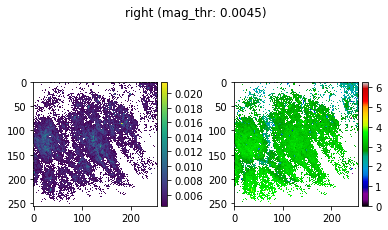

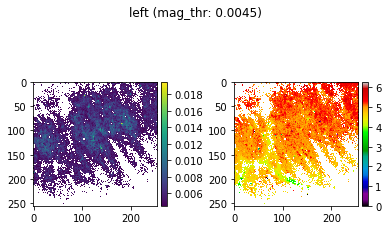

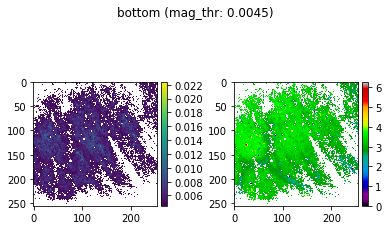

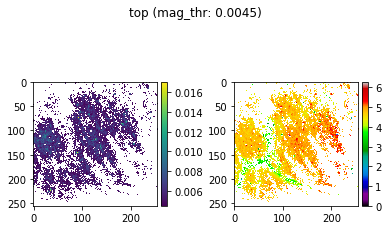

In [253]:

mag_thr = 0.0045
d2 = runinfo['pixels_per_line']
d1 = runinfo['lines_per_frame']

magmaps = {}
phasemaps = {}
magthrs = {}
for cond in trials_by_cond.keys():    
    magmaps[cond], phasemaps[cond], magthrs[cond] = filter_map_by_magratio(magratio, phase, cond=cond, mag_thr=mag_thr, dims=(d1, d2))
    fig = plot_filtered_maps(cond, magmaps[cond], phasemaps[cond], magthrs[cond])


absolute_az = (phasemaps['left'] - phasemaps['right']) / 2.
delay_az = (phasemaps['left'] + phasemaps['right']) / 2.


absolute_el = (phasemaps['bottom'] - phasemaps['top']) / 2.
delay_el = (phasemaps['bottom'] + phasemaps['top']) / 2.


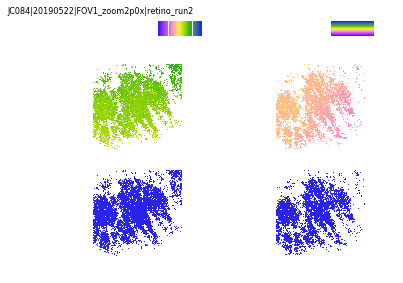

In [258]:
#%%
fig, axes = pl.subplots(2,2)
# im1 = axes[0,0].imshow(absolute_az, cmap='nipy_spectral_r', vmin=-np.pi, vmax=np.pi)
# im2 = axes[0,1].imshow(absolute_el, cmap='nipy_spectral_r', vmin=-np.pi, vmax=np.pi)
# axes[1,0].imshow(delay_az, cmap='nipy_spectral', vmin=-np.pi, vmax=np.pi)
# axes[1,1].imshow(delay_el, cmap='nipy_spectral', vmin=-np.pi, vmax=np.pi)
im1 = axes[0,0].imshow(absolute_az, cmap=cmap, vmin=-np.pi, vmax=np.pi)
im2 = axes[0,1].imshow(absolute_el, cmap=cmap, vmin=-np.pi, vmax=np.pi)
axes[1,0].imshow(delay_az, cmap=cmap, vmin=-np.pi, vmax=np.pi)
axes[1,1].imshow(delay_el, cmap=cmap, vmin=-np.pi, vmax=np.pi)

cbar1_orientation='horizontal'
cbar1_axes = [0.35, 0.9, 0.1, 0.05]
cbar2_orientation='vertical'
cbar2_axes = [0.75, 0.9, 0.1, 0.05]

cbaxes = fig.add_axes(cbar1_axes) 
cb = pl.colorbar(im1, cax = cbaxes, orientation=cbar1_orientation)  
cb.ax.axis('off')
cb.outline.set_visible(False)
cb.ax.axvline(cb.norm(-np.pi*elev_cutoff), color='w', lw=1)
cb.ax.axvline(cb.norm(np.pi*elev_cutoff), color='w', lw=1)


cbaxes = fig.add_axes(cbar2_axes) 
cb = pl.colorbar(im2, cax = cbaxes, orientation=cbar2_orientation)
#cb.ax.set_ylim([cb.norm(-np.pi*top_cutoff), cb.norm(np.pi*top_cutoff)])
# cb.ax.axhline(y=cb.norm(-np.pi*elev_cutoff), color='w', lw=1)
# cb.ax.axhline(y=cb.norm(np.pi*elev_cutoff), color='w', lw=1)
cb.ax.axis('off')
cb.outline.set_visible(False)

pl.subplots_adjust(top=0.8)

for ax in axes.flat:
    ax.axis('off')
    
figname = 'absolute-maps_%s_%s' % (colormap, skey)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, '%s.png' % (figname)))


In [ ]:
figname = 'absolute-maps_%s_%s' % (colormap, skey)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, '%s%s.png' % (figname, label_str)))


In [259]:
output_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/figure_panels'